# Estimate $\frac{\alpha}{\beta}$

In [1]:
## a bit of setup

import os
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
from src.utils.log_utils import get_name
from scipy.ndimage import gaussian_filter1d
from src.utils.file_utils import convert_dict_2_json, convert_json_2_dict

%load_ext autoreload
%autoreload 2

CURRENT_DIR = os.getcwd()
LOG_DIR = os.path.join(CURRENT_DIR, 'log')
GRAD_DIR = os.path.join(CURRENT_DIR, 'cache/grad')

Helper Functions

In [12]:
def first_upper(l, b):
    for i, x in enumerate(l):
        if x >= b:
            return i
    return len(l)-1

def first_lower(l, b):
    for i, x in enumerate(l):
        if x <= b:
            return i
    return len(l)-1   

%matplotlib inline
# plt.title("mnist 1-7 niid, system heter (with rp)")
def plot_figure(file_list, **kwargs):
    """Plot PK/Uniform figure
        - file_list
    """
    filter = kwargs.pop("filter", False)
    f_filter = kwargs.pop("f_filter", 5)
    use_time = kwargs.pop("use_time", False)
    algo_list = ['pk', 'uniform']
    for algo in algo_list:

        loss = np.mean([f['global_loss'] for f in file_list[algo]], axis=0)
        time = np.mean([f['round_time'] for f in file_list[algo]], axis=0)
        acc = np.mean([f['acc'] for f in file_list[algo]], axis=0)

        for i in range(1,len(time)):
            time[i] += time[i-1]
      
        if filter:
            loss = gaussian_filter1d(loss, sigma=f_filter)
        if use_time:
            plt.plot(time,loss)
        else:
            plt.plot(loss)
            
    plt.legend(algo_list)
    print('pk %d ; uniform %d' % (len(file_list['pk']), len(file_list['uniform'])))
    
plt.show()

#### config settings

In [6]:
PATH = 'test'

SMOOTH = True
f_smooth = 3

pk_config = {
    'algo': 'weighted',
    'decay' : 'round',
    'dataset'               : 'emnist_niid1_7_0_N1',
    'model'                 : 'logistic',
    'num_round'             : 10,
    'clients_per_round'     : 1,
    'batch_size'            : 24,
    'num_epoch'             : 50,
    'lr'                    : 0.1,
    'without_r'             : False,
    'num_clients'           : 1,
    'c0' : 5,
}

uniform_config = {
'algo': 'uniform',
    'decay' : 'round',
    'dataset'               : 'emnist_niid1_7_0_N1',
    'model'                 : 'logistic',
    'num_round'             : 10,
    'clients_per_round'     : 1,
    'batch_size'            : 24,
    'num_epoch'             : 50,
    'lr'                    : 0.1,
    'without_r'             : False,
    'num_clients'           : 1,
    'c0' : 5
}


#### Next step is to extract File

- get filename
- retrival and store file

In [10]:
file_list = {
    'pk'      : [],
    'uniform' : [],
}

cnt1, cnt2 = 0, 0
for time_setting in range(1,2):
    for seed in range(0,7):
        pk_config['time_seed'] = time_setting
        pk_config['seed'] = seed 
        uniform_config['time_seed'] = time_setting
        uniform_config['seed'] = seed 

        pk_name = get_name(pk_config)
        uniform_name = get_name(uniform_config)

        try:
            file_list['pk'].append(convert_json_2_dict(pk_name, os.path.join(LOG_DIR, PATH)))
            cnt1 += 1
        except:
            print(pk_name , "not exists")

        try:
            file_list['uniform'].append(convert_json_2_dict(uniform_name, os.path.join(LOG_DIR, PATH)))
            cnt2 += 1
        except:
            print(uniform_name, "not exists")
print(cnt1, cnt2)


weighted-emnist_niid1_7_0_N1-SEED0-TIME1-E50-K1-R10-C5-N1-Grad-logistic.json not exists
uniform-emnist_niid1_7_0_N1-SEED0-TIME1-E50-K1-R10-C5-N1-Grad-logistic.json not exists
6 6


#### Then plot the figure

pk 6 ; uniform 6


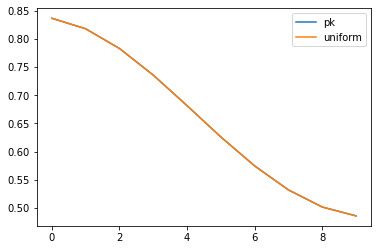

In [13]:
%matplotlib inline


plot_figure(file_list, filter=True, f_filter=5)

#### Estimation

- Extract gradient 
- calc $\frac{\alpha}{\beta}$

In [14]:
def extract_grad(file_list, algo, method):
    """Extract gradient
    """
    num_clients = file_list['pk'][0]['info']['num_clients']

    grads = []
    for f in file_list[algo]:
        grad_clients = [[] for i in range(num_clients)]
        selected_clients = np.array(f['sel_clients'])
        gk = np.array(f['gk']) # np.shape (round, client)
        
        for round, client in enumerate(selected_clients):
            for c in client:
                grad_clients[c].append( gk[round, c] )
        
        if method == 'MEAN':
            grad = [ np.mean(g) for g in grad_clients ]
        elif method == 'MAX':
            grad = [ np.max(g) for g in grad_clients ]
        elif method == 'FIRST':
            grad = [ g[0] for g in grad_clients ]
        else:
            raise Exception("Undefined method")
        
        grads.append(grad)

    return np.mean(grads, axis=0)

In [15]:
METHOD = 'MAX'

grad_uniform = extract_grad(file_list, 'uniform', METHOD)

grad_ret = grad_uniform

STORE = True 

if STORE:
    grad_name = get_name(pk_config, name_type='grad')
    convert_dict_2_json(grad_ret.tolist(), grad_name, GRAD_DIR)
    print("saved to %s %s" % (GRAD_DIR, grad_name))


KeyError: 'sel_clients'

In [70]:

def get_round(ths, loss, **kwargs):
    """Get the round no of specific loss value
    """
    method = kwargs.pop('method', 'head')
    if method == 'head':
        return first_lower(loss, ths)
    elif method == 'tail':
        return first_upper(reversed(loss), ths)

    
def estimate(fA, grad_ret, **kwargs):
    c0 = []
    
    num_clients = file_list['pk'][0]['info']['num_clients']
    prob_pk = file_list['pk'][0]['pk']

    loss1 = np.mean( [ f['loss'] for f in file_list['pk'] ], axis=0)
    loss2 = np.mean( [ f['loss'] for f in file_list['uniform'] ], axis=0)

    G1 = np.mean([ f['gk'] for f in file_list['pk']], axis=0)
    G2 = np.mean([ f['gk'] for f in file_list['uniform']], axis=0)

    loss1 = gaussian_filter1d(loss1, sigma=5)
    loss2 = gaussian_filter1d(loss2, sigma=5)
    
    r1 = get_round(fA, loss1, **kwargs)
    r2 = get_round(fA, loss2, **kwargs)
    
    K = file_list['pk'][0]['info']['clients_per_round']

    M = np.sum( np.array(prob_pk) * np.square(grad_ret) )
    N = num_clients * np.sum( np.square(prob_pk) * np.square(grad_ret) )

    c0 = (r1 * N - r2 * M) / (r2 - r1) 

    print(fA, r1, r2, M, N, c0)
    return c0 / K


In [ ]:

########### ############
ret_list = []
x = np.linspace(0.555,0.535,5) 

##############################
for fA in x:
    ret_list.append( estimate(fA, grad_ret, method='head') )

print("estimation result:",np.mean(ret_list))
